# Import Library

In [ ]:
# ===== Standard =====
import os
import shutil
import random
import time

# ===== Data =====
import numpy as np
import pandas as pd

# ===== Visualization =====
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# ===== Metrics =====
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)

# ===== TensorFlow / Keras =====
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# ===== Models =====
from tensorflow.keras.applications import (
    ResNet50,
    MobileNetV2,
    EfficientNetB0
)

# ===== Preprocess =====
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficient

# ===== Callbacks =====
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# Data Preparation

In [ ]:
!ls /kaggle/input/plantvillage-dataset/color

 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_virus
 Tomato_

In [ ]:
# CONFIG
SOURCE_DIR = "/kaggle/input/plantvillage-dataset/color"
TARGET_DIR = "/kaggle/working/tomato_split"

TRAIN_RATIO = 0.8
VAL_RATIO   = 0.1
TEST_RATIO  = 0.1
SEED = 42

random.seed(SEED)

TOMATO_CLASSES = [
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus"
]

## Data Splitting 80:10:10

In [ ]:
# CREATE OUTPUT FOLDERS

for split in ["train", "val", "test"]:
    for cls in TOMATO_CLASSES:
        os.makedirs(os.path.join(TARGET_DIR, split, cls), exist_ok=True)

print("[INFO] Folder structure created.")

# SPLIT & COPY DATA

for cls in TOMATO_CLASSES:
    src_cls_dir = os.path.join(SOURCE_DIR, cls)

    if not os.path.isdir(src_cls_dir):
        print(f"[WARNING] Class not found: {cls}")
        continue

    images = [
        f for f in os.listdir(src_cls_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    random.shuffle(images)

    total = len(images)
    n_train = int(total * TRAIN_RATIO)
    n_val   = int(total * VAL_RATIO)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train + n_val]
    test_imgs  = images[n_train + n_val:]

    def copy_images(img_list, split_name):
        for img in img_list:
            src = os.path.join(src_cls_dir, img)
            dst = os.path.join(TARGET_DIR, split_name, cls, img)
            shutil.copy2(src, dst)

    copy_images(train_imgs, "train")
    copy_images(val_imgs, "val")
    copy_images(test_imgs, "test")

    print(
        f"[OK] {cls}: "
        f"{len(train_imgs)} train | "
        f"{len(val_imgs)} val | "
        f"{len(test_imgs)} test"
    )

print("\n[SUCCESS] Tomato dataset splitting completed!")

[INFO] Folder structure created.
[OK] Tomato___Bacterial_spot: 1701 train | 212 val | 214 test
[OK] Tomato___Early_blight: 800 train | 100 val | 100 test
[OK] Tomato___healthy: 1272 train | 159 val | 160 test
[OK] Tomato___Late_blight: 1527 train | 190 val | 192 test
[OK] Tomato___Leaf_Mold: 761 train | 95 val | 96 test
[OK] Tomato___Septoria_leaf_spot: 1416 train | 177 val | 178 test
[OK] Tomato___Spider_mites Two-spotted_spider_mite: 1340 train | 167 val | 169 test
[OK] Tomato___Target_Spot: 1123 train | 140 val | 141 test
[OK] Tomato___Tomato_mosaic_virus: 298 train | 37 val | 38 test
[OK] Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4285 train | 535 val | 537 test

[SUCCESS] Tomato dataset splitting completed!


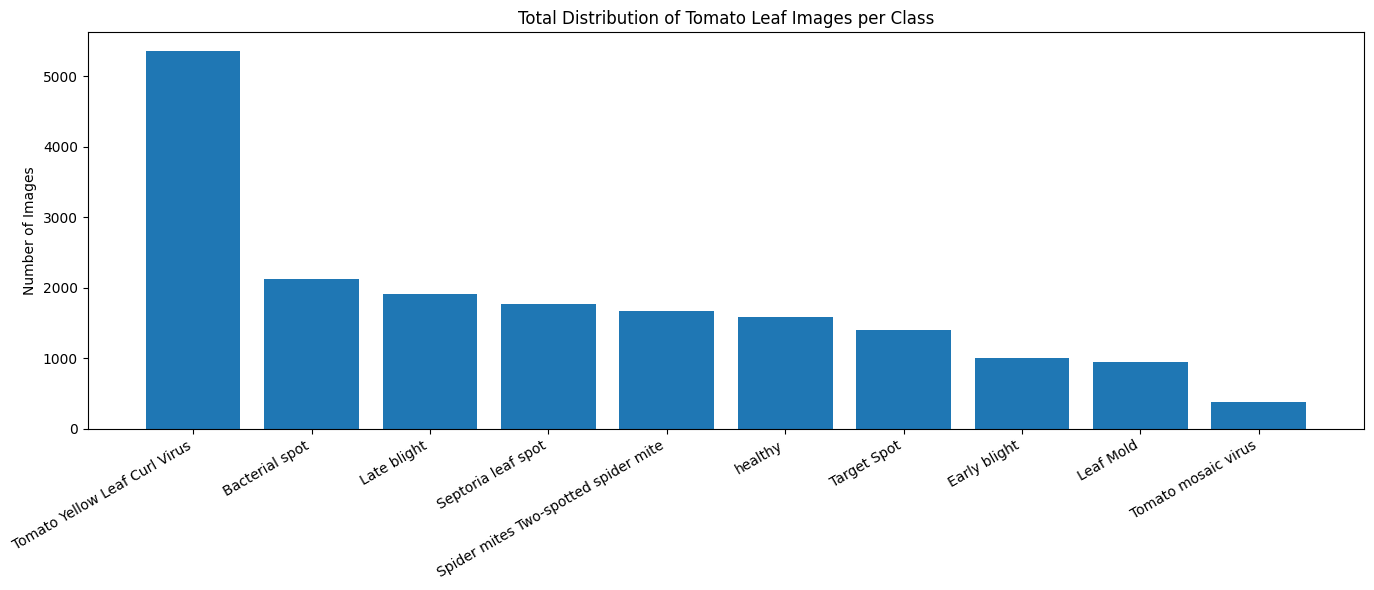

In [ ]:
def plot_class_distribution_total(source_dir, class_dirs):
    data = []

    for class_dir in class_dirs:
        class_path = os.path.join(source_dir, class_dir)

        if not os.path.isdir(class_path):
            print(f"Warning: {class_dir} not found")
            continue

        total_images = len([
            f for f in os.listdir(class_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])

        # Rapikan nama kelas untuk plot
        class_name = (
            class_dir
            .replace("Tomato___", "")
            .replace("_", " ")
        )

        data.append({
            "class": class_name,
            "total_images": total_images
        })

    df = pd.DataFrame(data).sort_values("total_images", ascending=False)

    plt.figure(figsize=(14, 6))
    plt.bar(df["class"], df["total_images"])
    plt.ylabel("Number of Images")
    plt.title("Total Distribution of Tomato Leaf Images per Class")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

plot_class_distribution_total(SOURCE_DIR, TOMATO_CLASSES)

## Image Sample from Each Tomato Classes

In [ ]:
def plot_one_sample_per_class(
    dataset_dir,
    classes,
    split="train",
    img_size=(224, 224),
    cols=5,
    seed=42
):
    random.seed(seed)

    n = len(classes)
    rows = (n + cols - 1) // cols
    fig = plt.figure(figsize=(cols * 4, rows * 4))

    for i, cls in enumerate(classes):
        cls_dir = os.path.join(dataset_dir, split, cls)
        imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        img = Image.open(os.path.join(cls_dir, random.choice(imgs))).convert("RGB")
        img = img.resize(img_size)

        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1)

        ax.text(
            0.5, -0.08,
            cls.replace("Tomato___", ""),
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10
        )

    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()


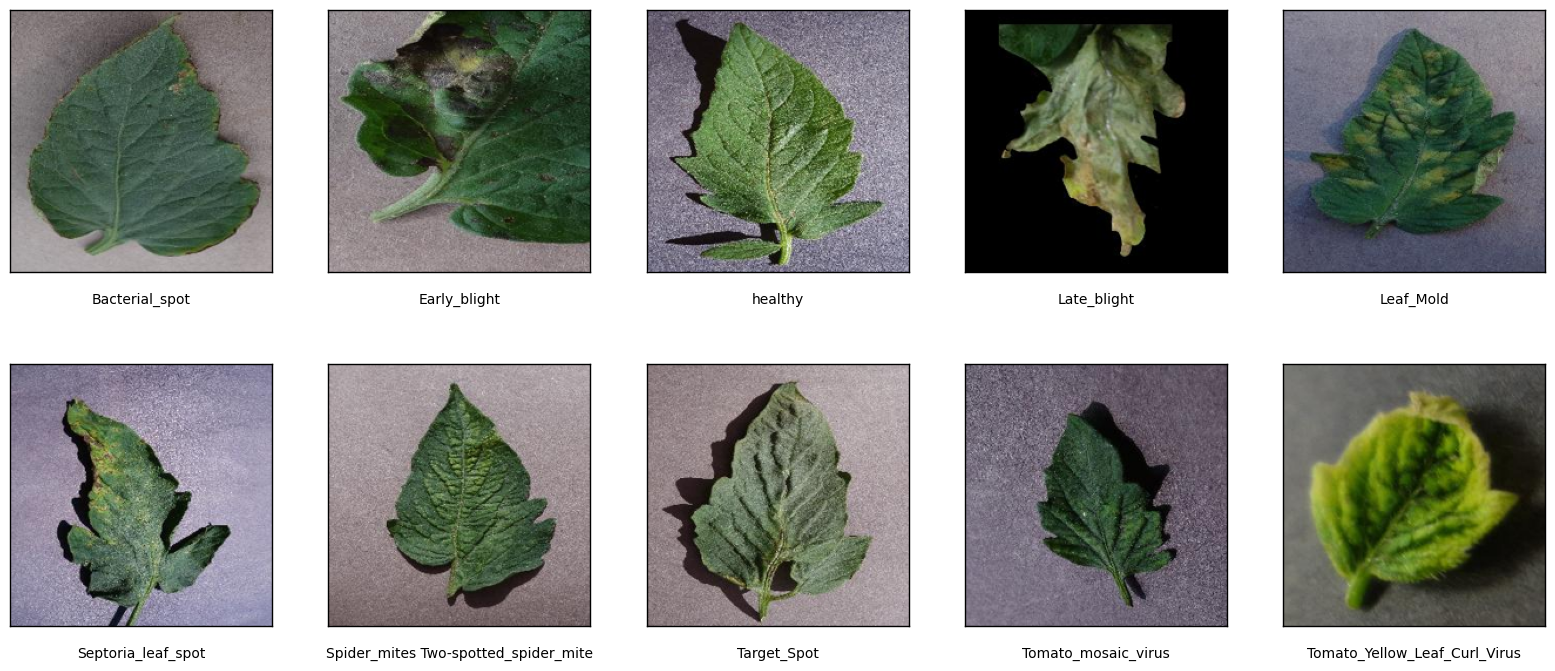

In [ ]:
DATASET_DIR = "/kaggle/working/tomato_split"

plot_one_sample_per_class(
    dataset_dir=DATASET_DIR,
    classes=TOMATO_CLASSES,
    split="train",
    img_size=(224, 224),
    cols=5
)

# Data Preprocessing

## tf.data Dataset Generation (Resizing, Batching, Shuffling, and Model-Specific Preprocessing)

In [ ]:
root = "/kaggle/working/tomato_split/"
train_dir = root + "train"
test_dir = root + "test"
val_dir = root + "val"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
], name="data_augmentation")

I0000 00:00:1767694846.456830      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767694846.460694      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
def load_dataset(
    directory,
    preprocess_fn,
    augment=False,
    shuffle=True
):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=shuffle,
        seed=SEED
    )

    def apply_ops(x, y):
        if augment:
            x = data_augmentation(x, training=True)
        x = preprocess_fn(x)
        return x, y

    ds = ds.map(
        apply_ops,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return ds.prefetch(tf.data.AUTOTUNE)


In [ ]:
train_resnet = load_dataset(
    train_dir,
    preprocess_resnet,
    augment=True,
    shuffle=True
)

val_resnet = load_dataset(
    val_dir,
    preprocess_resnet,
    augment=False,
    shuffle=False
)

test_resnet = load_dataset(
    test_dir,
    preprocess_resnet,
    shuffle=False
)

Found 14523 files belonging to 10 classes.
Found 1812 files belonging to 10 classes.
Found 1825 files belonging to 10 classes.


In [ ]:
train_mobilenet = load_dataset(
    train_dir,
    preprocess_mobilenet,
    augment=True,
    shuffle=True
)

val_mobilenet = load_dataset(
    val_dir,
    preprocess_mobilenet,
    augment=False,
    shuffle=False
)

test_mobilenet = load_dataset(
    test_dir,
    preprocess_mobilenet,
    augment=False,
    shuffle=False
)


Found 14523 files belonging to 10 classes.
Found 1812 files belonging to 10 classes.
Found 1825 files belonging to 10 classes.


In [ ]:
train_efficient = load_dataset(
    train_dir,
    preprocess_efficient,
    augment=True,
    shuffle=True
)

val_efficient = load_dataset(
    val_dir,
    preprocess_efficient,
    augment=False,
    shuffle=False
)

test_efficient = load_dataset(
    test_dir,
    preprocess_efficient,
    augment=False,
    shuffle=False
)


Found 14523 files belonging to 10 classes.
Found 1812 files belonging to 10 classes.
Found 1825 files belonging to 10 classes.


# Inference

In [ ]:
!ls /kaggle/input/model-paper-viskom/keras/default/1

ls: cannot access '/kaggle/input/model-paper-viskom/keras/default/1': No such file or directory


In [ ]:
class_names = [
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___healthy"
]

In [ ]:
from tensorflow.keras.models import load_model

# ===== ResNet50 =====
resnet50_ft20   = load_model("/kaggle/input/model-viskom/keras/default/1/resnet50_ft20.keras")
resnet50_ft40   = load_model("/kaggle/input/model-viskom/keras/default/1/resnet50_ft40.keras")
resnet50_freeze = load_model("/kaggle/input/model-viskom/keras/default/1/resnet50_freeze_all.keras")

# ===== MobileNetV2 =====
mobilenet_ft20   = load_model("/kaggle/input/model-viskom/keras/default/1/mobilenetv2_ft20.keras")
mobilenet_ft40   = load_model("/kaggle/input/model-viskom/keras/default/1/mobilenetv2_ft40.keras")
mobilenet_freeze = load_model("/kaggle/input/model-viskom/keras/default/1/mobilenetv2_freeze_all.keras")

# ===== EfficientNetB0 =====
efficientnet_ft20   = load_model("/kaggle/input/model-viskom/keras/default/1/efficientnetb0_ft20.keras")
efficientnet_ft40   = load_model("/kaggle/input/model-viskom/keras/default/1/efficientnetb0_ft40.keras")
efficientnet_freeze = load_model("/kaggle/input/model-viskom/keras/default/1/efficientnetb0_freeze_all.keras")

In [ ]:
MODELS_FOR_TEST = {
    "ResNet50_ft20": {
        "model": resnet50_ft20,
        "preprocess": preprocess_resnet
    },
    "ResNet50_ft40": {
        "model": resnet50_ft40,
        "preprocess": preprocess_resnet
    },
    "ResNet50_freeze": {
        "model": resnet50_freeze,
        "preprocess": preprocess_resnet
    },

    "MobileNetV2_ft20": {
        "model": mobilenet_ft20,
        "preprocess": preprocess_mobilenet
    },
    "MobileNetV2_ft40": {
        "model": mobilenet_ft40,
        "preprocess": preprocess_mobilenet
    },
    "MobileNetV2_freeze": {
        "model": mobilenet_freeze,
        "preprocess": preprocess_mobilenet
    },

    "EfficientNetB0_ft20": {
        "model": efficientnet_ft20,
        "preprocess": preprocess_efficient
    },
    "EfficientNetB0_ft40": {
        "model": efficientnet_ft40,
        "preprocess": preprocess_efficient
    },
    "EfficientNetB0_freeze": {
        "model": efficientnet_freeze,
        "preprocess": preprocess_efficient
    }
}

In [ ]:
def gpu_sync():
    if tf.config.list_physical_devices('GPU'):
        tf.constant(0).numpy()


def inference_time_per_model(
    model,
    preprocess_fn,
    test_ds,
    model_name,
    warmup_steps=10
):
    times = []

    # WARM-UP
    for images, _ in test_ds.take(1):
        images = preprocess_fn(images)
        for i in range(min(warmup_steps, images.shape[0])):
            img = tf.expand_dims(images[i], axis=0)
            _ = model(img, training=False)
            gpu_sync()

    # TIMING
    for images, _ in test_ds:
        images = preprocess_fn(images)

        for i in range(len(images)):
            img = tf.expand_dims(images[i], axis=0)

            start = time.perf_counter()
            _ = model(img, training=False)
            gpu_sync()
            end = time.perf_counter()

            times.append(end - start)

    return {
        "Model": model_name,
        "Mean (ms)": np.mean(times) * 1000,
        "Std (ms)": np.std(times) * 1000
    }

In [ ]:
results = []

for idx, (model_name, cfg) in enumerate(MODELS_FOR_TEST.items(), start=1):
    if "ResNet" in model_name:
        test_ds = test_resnet
    elif "MobileNet" in model_name:
        test_ds = test_mobilenet
    else:
        test_ds = test_efficient

    res = inference_time_per_model(
        model=cfg["model"],
        preprocess_fn=cfg["preprocess"],
        test_ds=test_ds,
        model_name=model_name
    )

    res["No"] = idx
    results.append(res)

df_latency = pd.DataFrame(results)[
    ["No", "Model", "Mean (ms)", "Std (ms)"]
]

df_latency

No                  Model   Mean (ms)   Std (ms)
0   1          ResNet50_ft20  206.783931   5.628377
1   2          ResNet50_ft40  206.353859   6.552317
2   3        ResNet50_freeze  205.866278   5.705393
3   4       MobileNetV2_ft20  131.603047   5.383333
4   5       MobileNetV2_ft40  131.101031   4.696641
5   6     MobileNetV2_freeze  132.825131   5.150092
6   7    EfficientNetB0_ft20  260.946622  14.045658
7   8    EfficientNetB0_ft40  258.448377   8.489054
8   9  EfficientNetB0_freeze  257.292867   8.097684

# Grad-CAM

In [ ]:
def gradcam_heatmap(model, img, last_conv_layer):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_out = conv_out[0]
    heatmap = conv_out @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy(), class_idx.numpy()

In [ ]:
def gradcam_5x2_random(
    test_ds,
    model,
    class_names,
    last_conv_layer="top_conv",
    seed=None
):
    if seed is not None:
        tf.random.set_seed(seed)

    test_ds = test_ds.shuffle(2000)

    samples = []
    class_counter = {i: 0 for i in range(len(class_names))}
    MAX_PER_CLASS = 2
    MAX_CLASSES = 5

    for images, labels in test_ds:
        for i in range(len(images)):
            true_cls = int(tf.argmax(labels[i]))

            # Skip if class quota full
            if class_counter[true_cls] >= MAX_PER_CLASS:
                continue

            # Stop if already 5 classes collected
            used_classes = [k for k, v in class_counter.items() if v > 0]
            if len(used_classes) >= MAX_CLASSES and true_cls not in used_classes:
                continue

            img = images[i:i+1]

            heatmap, pred = gradcam_heatmap(
                model, img, last_conv_layer
            )

            # Original image
            img_np = images[i].numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            img_np = np.uint8(255 * img_np)

            heatmap = cv2.resize(heatmap, (224, 224))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

            gradcam = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

            gradcam = cv2.copyMakeBorder(
                gradcam, 3, 3, 3, 3,
                cv2.BORDER_CONSTANT,
                value=(0, 0, 0)
            )

            original = cv2.copyMakeBorder(
                img_np, 3, 3, 3, 3,
                cv2.BORDER_CONSTANT,
                value=(0, 0, 0)
            )

            samples.append((gradcam, original, true_cls, pred))
            class_counter[true_cls] += 1

            # Stop condition
            if sum(class_counter.values()) == MAX_CLASSES * MAX_PER_CLASS:
                break

        if sum(class_counter.values()) == MAX_CLASSES * MAX_PER_CLASS:
            break

    # ===== Plot 4x5 =====
    fig, axes = plt.subplots(4, 5, figsize=(22, 14))

    for idx, (gradcam_img, original_img, true_cls, pred) in enumerate(samples):
        col = idx % 5
        row_gradcam = idx // 5
        row_original = row_gradcam + 2

        axes[row_gradcam, col].imshow(gradcam_img)
        axes[row_gradcam, col].axis("off")
        axes[row_gradcam, col].set_title(
            f"T: {class_names[true_cls].replace('Tomato___','')}\n"
            f"P: {class_names[pred].replace('Tomato___','')}",
            fontsize=9
        )

        axes[row_original, col].imshow(original_img)
        axes[row_original, col].axis("off")
        axes[row_original, col].set_title("Original", fontsize=9)

    plt.suptitle(
        "Grad-CAM Visualization (5 Classes × 2 Samples)",
        fontsize=16
    )
    plt.tight_layout()
    plt.show()

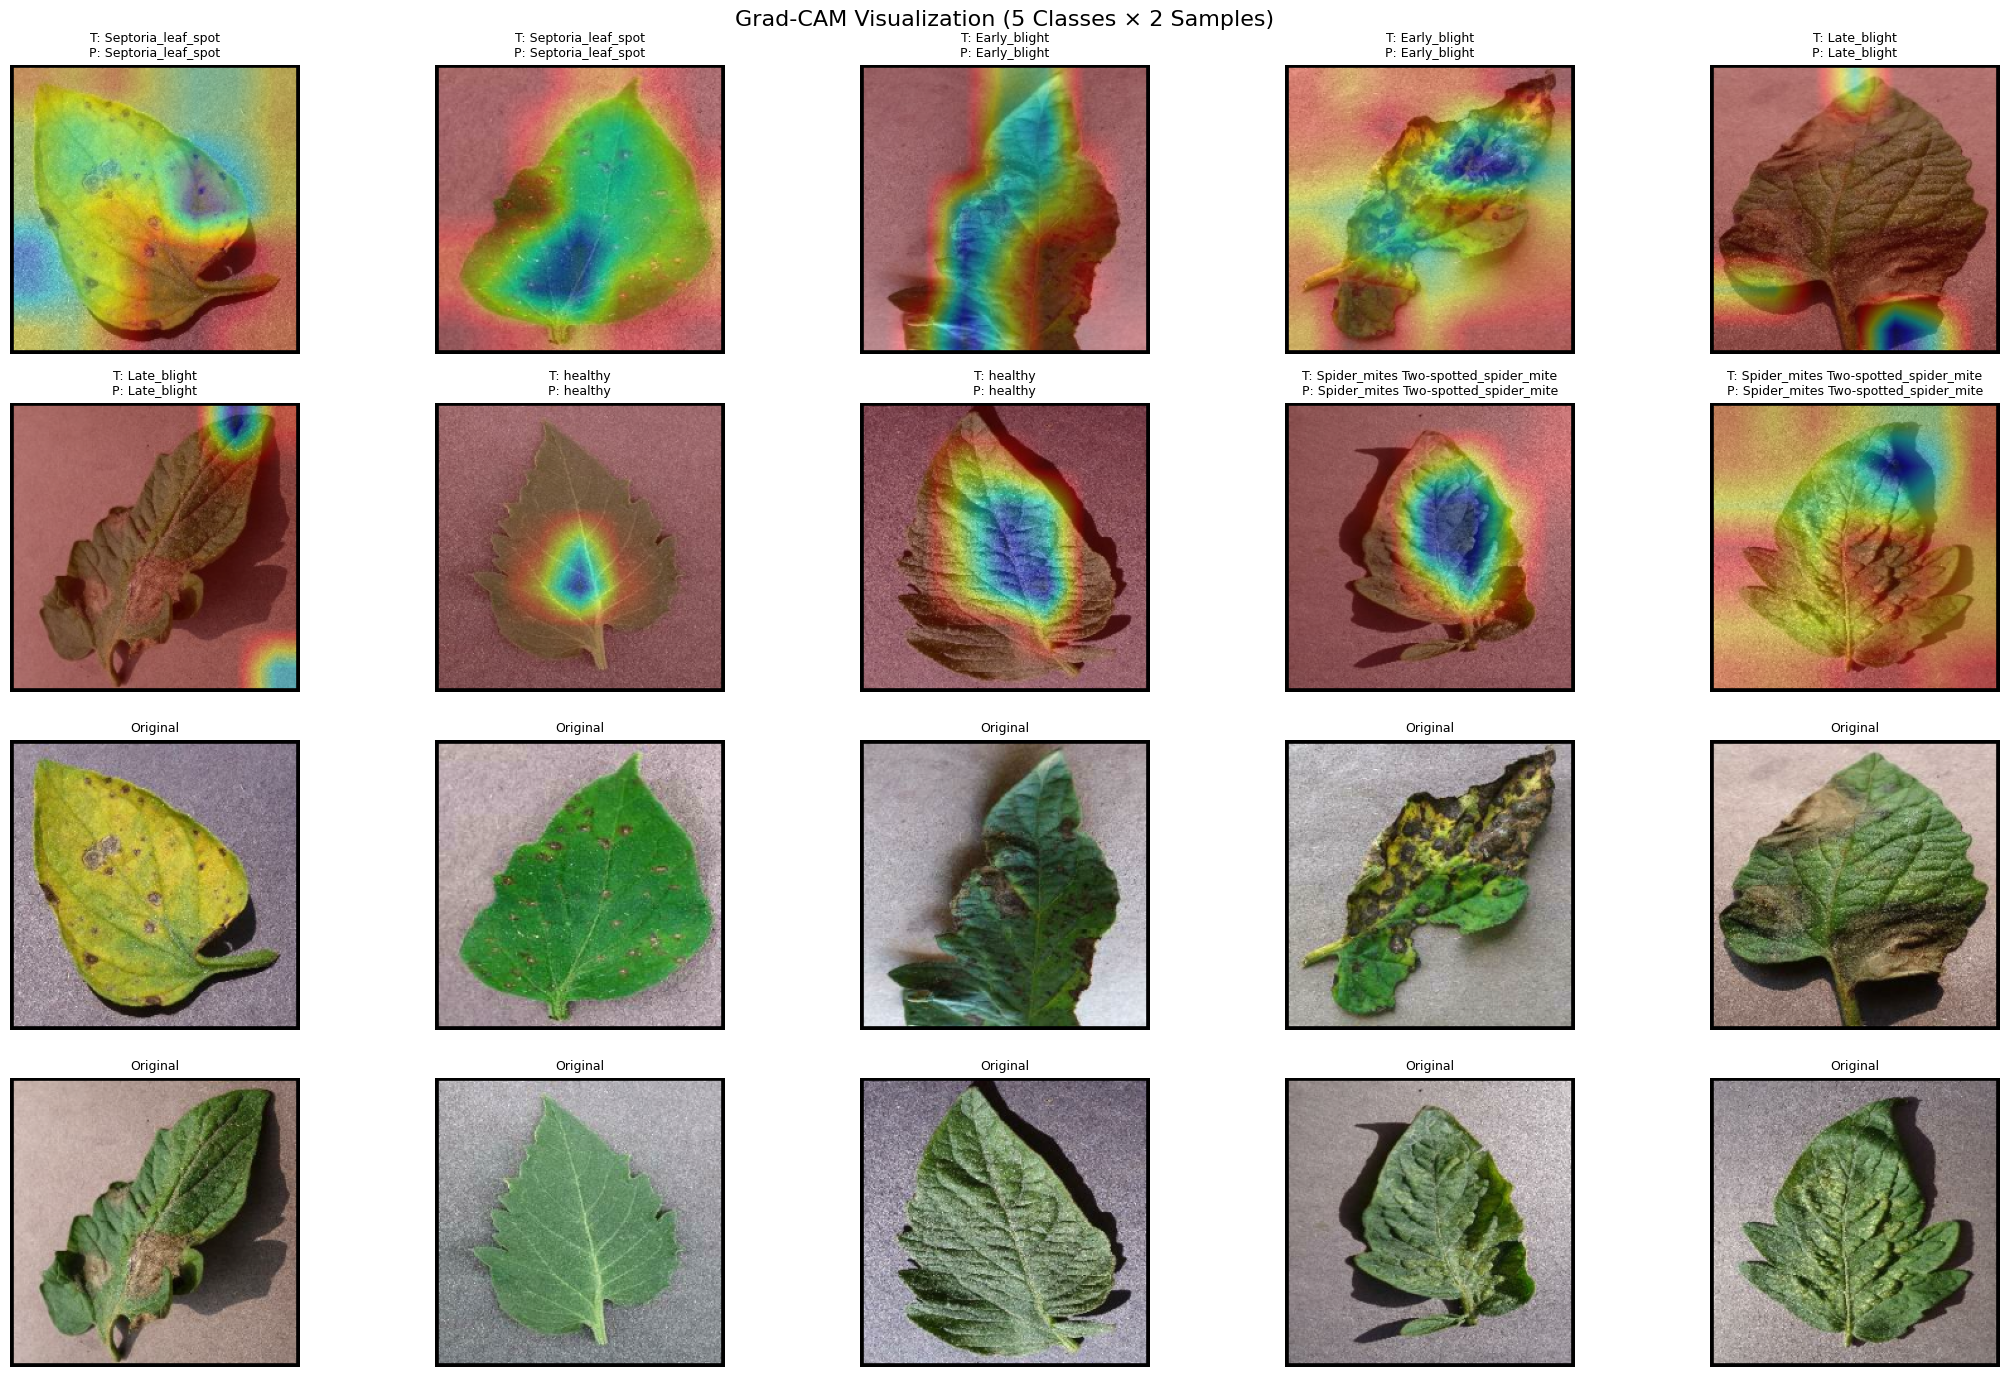

In [ ]:
gradcam_5x2_random(
    test_ds=test_efficient,
    model=efficientnet_ft40,
    class_names=class_names,
)